# **Análise de Dados de Entregas da Empresa Log no Distrito Federal**

## 1\. Contexto

A empresa Log é uma startup unicórnio brasileira de tecnologia focada em logística que faz suas entregas através de hubs (centros de distribuição) diferentes e vou utilizar os dados de entregas disponibilizados do Distrito Federal. Este projeto visa examinar dados de entrega, identificar padrões e extrair insights que possam aprimorar as operações da empresa. Serão examinadas a distribuição das entregas, as distâncias percorridas e as coordenadas dos hubs e pontos de entrega. O conjunto de dados será aumentado com informações geográficas de cidades e bairros para melhorar a compreensão espacial das operações e trazer mais clareza para o projeto.

## 2\. Pacotes e bibliotecas

In [2]:
# Bibliotecas Padrão
import pandas as pd
import numpy as np

# Bibliotecas de Terceiros
import json
import matplotlib.pyplot as plt
import seaborn as sns

# Biblioteca para geocodificação (Geopy)
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from geopy.distance import geodesic

import geopandas


## 3\. Exploração de dados

### 3.2. Carregamento e criação do DataFrame Pandas

Aqui vou abrir o arquivo `deliveries.json` e transforma-lo em um dicionário nomeado como `data`

In [3]:
#abrindo o arquivo em modo leitura
with open('deliveries.json', mode='r', encoding='utf8') as file:
    data = json.load(file)

#transformando o arquivo json em um df pandas
deliveries_df = pd.DataFrame(data)


### 3.3. Explorando o DataFrame

Nos passos abaixo vou explorar um pouco a estrutura e coletar alguns dados.

In [4]:
#vizualização do df
deliveries_df.head()

,name,region,origin,vehicle_capacity,deliveries
0,cvrp-2-df-33,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'p..."
1,cvrp-2-df-73,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'bf3fc630b1c29601a4caf1bdd474b85', 'po..."
2,cvrp-2-df-20,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'b30f1145a2ba4e0b9ac0162b68d045c3', 'p..."
3,cvrp-1-df-71,df-1,"{'lng': -47.89366206897872, 'lat': -15.8051175...",180,"[{'id': 'be3ed547394196c12c7c27c89ac74ed6', 'p..."
4,cvrp-2-df-87,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'a6328fb4dc0654eb28a996a270b0f6e4', 'p..."


In [5]:
len(data)

199

In [6]:
#nome das colunas
example = data[0]
print(example.keys())

dict_keys(['name', 'region', 'origin', 'vehicle_capacity', 'deliveries'])


In [7]:
#
example['name']

'cvrp-2-df-33'

In [8]:
#nome da regiao de entrega do hub
example['region']

'df-2'

In [9]:
#capacidade do veiculo
example['vehicle_capacity']

180

In [10]:

# Informações gerais do DataFrame
deliveries_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199 entries, 0 to 198
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   name              199 non-null    object
 1   region            199 non-null    object
 2   origin            199 non-null    object
 3   vehicle_capacity  199 non-null    int64 
 4   deliveries        199 non-null    object
dtypes: int64(1), object(4)
memory usage: 7.9+ KB


In [11]:

# Verificar a quantidade de linhas e colunas
deliveries_df.shape


(199, 5)

In [12]:

# Estatísticas descritivas
deliveries_df.describe()

,vehicle_capacity
count,199.0
mean,180.0
std,0.0
min,180.0
25%,180.0
50%,180.0
75%,180.0
max,180.0


## 4\. Wrangling da Estrutura de dados

Aqui vou ajustar a estrutura do DataFrame, separando as coordenadas de origem e dos pontos de entrega colocando os endereços. Começando pela coluna `origin`

In [13]:
#criando df e removendo o aninhamento da coluna origin que fica a latitute e longitude dos hubs

hubs_df = pd.json_normalize(deliveries_df['origin'])
hubs_df.head()


,lng,lat
0,-48.054989,-15.838145
1,-48.054989,-15.838145
2,-48.054989,-15.838145
3,-47.893662,-15.805118
4,-48.054989,-15.838145


In [14]:
#fazendo o agrupamento das colunas criadas no dedf original

deliveries_df = pd.merge(left=deliveries_df, right=hubs_df, how='inner', left_index=True, right_index=True)
deliveries_df.head()

,name,region,origin,vehicle_capacity,deliveries,lng,lat
0,cvrp-2-df-33,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'p...",-48.054989,-15.838145
1,cvrp-2-df-73,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'bf3fc630b1c29601a4caf1bdd474b85', 'po...",-48.054989,-15.838145
2,cvrp-2-df-20,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'b30f1145a2ba4e0b9ac0162b68d045c3', 'p...",-48.054989,-15.838145
3,cvrp-1-df-71,df-1,"{'lng': -47.89366206897872, 'lat': -15.8051175...",180,"[{'id': 'be3ed547394196c12c7c27c89ac74ed6', 'p...",-47.893662,-15.805118
4,cvrp-2-df-87,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'a6328fb4dc0654eb28a996a270b0f6e4', 'p...",-48.054989,-15.838145


In [15]:
#removendo coluna origin, reorganizando e renomeando as colunas adicionadas

deliveries_df = deliveries_df.drop('origin', axis=1)#removendo a coluna origin
deliveries_df = deliveries_df[['name', 'region', 'lng', 'lat', 'vehicle_capacity', 'deliveries']]#reorganizando colunas na ordem desejada
deliveries_df.rename(columns={'lng': 'hub_lng', 'lat': 'hub_lat'}, inplace=True)#renomeando colunas para melhor entendimento
deliveries_df.head()

,name,region,hub_lng,hub_lat,vehicle_capacity,deliveries
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,"[{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'p..."
1,cvrp-2-df-73,df-2,-48.054989,-15.838145,180,"[{'id': 'bf3fc630b1c29601a4caf1bdd474b85', 'po..."
2,cvrp-2-df-20,df-2,-48.054989,-15.838145,180,"[{'id': 'b30f1145a2ba4e0b9ac0162b68d045c3', 'p..."
3,cvrp-1-df-71,df-1,-47.893662,-15.805118,180,"[{'id': 'be3ed547394196c12c7c27c89ac74ed6', 'p..."
4,cvrp-2-df-87,df-2,-48.054989,-15.838145,180,"[{'id': 'a6328fb4dc0654eb28a996a270b0f6e4', 'p..."


Agora vou trabalhar na coluna `deliveries` que possui um aninhamento mais complicado usando o `explode` que transforma cada elemento da lista em uma linha

In [16]:
#usando a operação explode na coluna deliveries

deliveries_exploded_df = deliveries_df[['deliveries']].explode('deliveries')
deliveries_exploded_df.head()

,deliveries
0,"{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'po..."
0,"{'id': '320c94b17aa685c939b3f3244c3099de', 'po..."
0,"{'id': '3663b42f4b8decb33059febaba46d5c8', 'po..."
0,"{'id': 'e11ab58363c38d6abc90d5fba87b7d7', 'poi..."
0,"{'id': '54cb45b7bbbd4e34e7150900f92d7f4b', 'po..."


In [17]:
#normalizando e renomeando as colunas
deliveries_normalized_df = pd.concat([
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["size"])).rename(columns={"deliveries": "delivery_size"}),
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["point"]["lng"])).rename(columns={"deliveries": "delivery_lng"}),
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["point"]["lat"])).rename(columns={"deliveries": "delivery_lat"}),
], axis= 1)
deliveries_normalized_df.head()

,delivery_size,delivery_lng,delivery_lat
0,9,-48.116189,-15.848929
0,2,-48.118195,-15.850772
0,1,-48.112483,-15.847871
0,2,-48.118023,-15.846471
0,7,-48.114898,-15.858055


Vou conferir agora se os dados estão intactos ou se houve alguma perda

In [18]:
len(deliveries_exploded_df)

636149

In [19]:
len(deliveries_normalized_df)

636149

Agora vou fazer o `drop` da coluna deliveries e o `merge` para juntar e renomear as colunas

In [20]:
deliveries_df = deliveries_df.drop("deliveries", axis=1)#removendo a coluna deliveries
deliveries_df = pd.merge(left=deliveries_df, right=deliveries_normalized_df, how='right', left_index=True, right_index=True)#adicionando as colunas no df original

#remove a coluna atual do índice do df e cria um novo índice inteiro, começando do zero e adicionando em um para cada linha.
deliveries_df.reset_index(inplace=True, drop=True)

deliveries_df.head()

,name,region,hub_lng,hub_lat,vehicle_capacity,delivery_size,delivery_lng,delivery_lat
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,9,-48.116189,-15.848929
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118195,-15.850772
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,1,-48.112483,-15.847871
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118023,-15.846471
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,7,-48.114898,-15.858055


Vou verificar mais uma vez se os dados continuam intactos

In [21]:
len(deliveries_df)

636149

In [22]:
deliveries_df.shape

(636149, 8)

Geocodificação reversa do hub

In [23]:
hubs_df = deliveries_df[["region", "hub_lng", "hub_lat"]]
hubs_df = hubs_df.drop_duplicates().sort_values(by="region").reset_index(drop=True)
hubs_df.head()

,region,hub_lng,hub_lat
0,df-0,-47.802665,-15.657014
1,df-1,-47.893662,-15.805118
2,df-2,-48.054989,-15.838145


Agora vou configurar biblioteca `Geopy` para obter as informações de cidade e bairro com base nas coordenadas e aplicar a geocodificação das três regiões e extrair informações de cidade e bairro.

In [24]:
# Configurando a biblioteca Geopy
geolocator = Nominatim(user_agent="alex_geocoder")
location = geolocator.reverse("-15.657013854445248, -47.802664728268745")

print(json.dumps(location.raw, indent=2, ensure_ascii=False))

{
  "place_id": 46410411,
  "licence": "Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright",
  "osm_type": "way",
  "osm_id": 240210480,
  "lat": "-15.656916027876347",
  "lon": "-47.80264463632131",
  "class": "highway",
  "type": "secondary",
  "place_rank": 26,
  "importance": 0.0533433333333333,
  "addresstype": "road",
  "name": "Rua 7",
  "display_name": "Rua 7, Quadra 2, Sobradinho, Região Geográfica Imediata do Distrito Federal, Região Integrada de Desenvolvimento do Distrito Federal e Entorno, Região Geográfica Intermediária do Distrito Federal, Distrito Federal, Região Centro-Oeste, 73015-127, Brasil",
  "address": {
    "road": "Rua 7",
    "residential": "Quadra 2",
    "suburb": "Sobradinho",
    "town": "Sobradinho",
    "municipality": "Região Geográfica Imediata do Distrito Federal",
    "county": "Região Integrada de Desenvolvimento do Distrito Federal e Entorno",
    "state_district": "Região Geográfica Intermediária do Distrito Federal",
    "state

In [25]:
geocoder = RateLimiter(geolocator.reverse, min_delay_seconds=1)

hubs_df["coordinates"] = hubs_df["hub_lat"].astype(str)  + ", " + hubs_df["hub_lng"].astype(str)
hubs_df["geodata"] = hubs_df["coordinates"].apply(geocoder)
hubs_df.head()

,region,hub_lng,hub_lat,coordinates,geodata
0,df-0,-47.802665,-15.657014,"-15.657013854445248, -47.802664728268745","(Rua 7, Quadra 2, Sobradinho, Região Geográfic..."
1,df-1,-47.893662,-15.805118,"-15.80511751066334, -47.89366206897872","(SQS 303, Asa Sul, Brasília, Plano Piloto, Reg..."
2,df-2,-48.054989,-15.838145,"-15.83814451122274, -48.05498915846707","(Armazém do Bolo, lote 4/8, CSB 4/5, Taguating..."


In [26]:
hub_geodata_df = pd.json_normalize(hubs_df["geodata"].apply(lambda data: data.raw))
hub_geodata_df.head()

,place_id,licence,osm_type,osm_id,lat,lon,class,type,place_rank,importance,...,address.state,address.ISO3166-2-lvl4,address.region,address.postcode,address.country,address.country_code,address.neighbourhood,address.city,address.shop,address.house_number
0,46410411,"Data © OpenStreetMap contributors, ODbL 1.0. h...",way,240210480,-15.656916027876347,-47.80264463632131,highway,secondary,26,0.053343,...,Distrito Federal,BR-DF,Região Centro-Oeste,73015-127,Brasil,br,NaN,NaN,NaN,NaN
1,46401425,"Data © OpenStreetMap contributors, ODbL 1.0. h...",way,66353368,-15.805172753950067,-47.89372354453109,highway,residential,26,0.053411,...,Distrito Federal,BR-DF,Região Centro-Oeste,70336-000,Brasil,br,SQS 303,Brasília,NaN,NaN
2,43777060,"Data © OpenStreetMap contributors, ODbL 1.0. h...",node,6249717596,-15.8384371,-48.0552917,shop,pastry,30,0.000010,...,Distrito Federal,BR-DF,Região Centro-Oeste,72015-030,Brasil,br,NaN,Taguatinga,Armazém do Bolo,lote 4/8


In [27]:
hub_geodata_df = hub_geodata_df[["address.town", "address.suburb", "address.city"]]
hub_geodata_df.rename(columns={"address.town": "hub_town", "address.suburb": "hub_suburb", "address.city": "hub_city"}, inplace=True)
hub_geodata_df["hub_city"] = np.where(hub_geodata_df["hub_city"].notna(), hub_geodata_df["hub_city"], hub_geodata_df["hub_town"])
hub_geodata_df["hub_suburb"] = np.where(hub_geodata_df["hub_suburb"].notna(), hub_geodata_df["hub_suburb"], hub_geodata_df["hub_city"])
hub_geodata_df = hub_geodata_df.drop("hub_town", axis=1)
hub_geodata_df.head()

<ipython-input-27-e7ffd1c368d3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hub_geodata_df.rename(columns={"address.town": "hub_town", "address.suburb": "hub_suburb", "address.city": "hub_city"}, inplace=True)
<ipython-input-27-e7ffd1c368d3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hub_geodata_df["hub_city"] = np.where(hub_geodata_df["hub_city"].notna(), hub_geodata_df["hub_city"], hub_geodata_df["hub_town"])
<ipython-input-27-e7ffd1c368d3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

,hub_suburb,hub_city
0,Sobradinho,Sobradinho
1,Asa Sul,Brasília
2,Taguatinga,Taguatinga


Juntei as informações de cidade e bairro do DataFrame hub_geodata_df com os dados de entregas do DataFrame deliveries_df.

In [28]:
hubs_df = pd.merge(left=hubs_df, right=hub_geodata_df, left_index=True, right_index=True)
hubs_df = hubs_df[["region", "hub_suburb", "hub_city"]]
hubs_df.head()

,region,hub_suburb,hub_city
0,df-0,Sobradinho,Sobradinho
1,df-1,Asa Sul,Brasília
2,df-2,Taguatinga,Taguatinga


In [29]:
deliveries_df = pd.merge(left=deliveries_df, right=hubs_df, how="inner", on="region")
deliveries_df = deliveries_df[["name", "region", "hub_lng", "hub_lat", "hub_city", "hub_suburb", "vehicle_capacity", "delivery_size", "delivery_lng", "delivery_lat"]]
deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055


###Geocodificação reversa da entrega

Como o volume de dados da coluna entregas é muito grande (demoraria 7 dias) o tutor disponibilizou um arquivo `csv` pronto para manipularmos

In [30]:
!wget -q "https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries-geodata.csv" -O deliveries-geodata.csv

In [32]:
deliveries_geodata_df = pd.read_csv("deliveries-geodata.csv")
deliveries_geodata_df.head()

,delivery_lng,delivery_lat,delivery_city,delivery_suburb
0,-48.116189,-15.848929,Ceilândia,P Sul
1,-48.118195,-15.850772,Ceilândia,P Sul
2,-48.112483,-15.847871,Ceilândia,P Sul
3,-48.118023,-15.846471,Ceilândia,P Sul
4,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol


Juntando os arquivos nas colunas

In [33]:
deliveries_df = pd.merge(left=deliveries_df, right=deliveries_geodata_df[["delivery_city", "delivery_suburb"]], how="inner", left_index=True, right_index=True)
deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat,delivery_city,delivery_suburb
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929,Ceilândia,P Sul
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772,Ceilândia,P Sul
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871,Ceilândia,P Sul
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471,Ceilândia,P Sul
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol


Verificando a qualidade dos dados

In [34]:
deliveries_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 636149 entries, 0 to 636148
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   name              636149 non-null  object 
 1   region            636149 non-null  object 
 2   hub_lng           636149 non-null  float64
 3   hub_lat           636149 non-null  float64
 4   hub_city          636149 non-null  object 
 5   hub_suburb        636149 non-null  object 
 6   vehicle_capacity  636149 non-null  int64  
 7   delivery_size     636149 non-null  int64  
 8   delivery_lng      636149 non-null  float64
 9   delivery_lat      636149 non-null  float64
 10  delivery_city     634447 non-null  object 
 11  delivery_suburb   476264 non-null  object 
dtypes: float64(4), int64(2), object(6)
memory usage: 58.2+ MB


In [35]:
deliveries_df.isna().any()

name                False
region              False
hub_lng             False
hub_lat             False
hub_city            False
hub_suburb          False
vehicle_capacity    False
delivery_size       False
delivery_lng        False
delivery_lat        False
delivery_city        True
delivery_suburb      True
dtype: bool

- **Geocodificação reversa**

In [36]:
100 * (deliveries_df["delivery_city"].isna().sum() / len(deliveries_df))
100 * (deliveries_df["delivery_suburb"].isna().sum() / len(deliveries_df))
prop_df = deliveries_df[["delivery_city"]].value_counts() / len(deliveries_df)
prop_df.sort_values(ascending=False).head(10)

delivery_city       
Brasília                0.234195
Taguatinga              0.071625
Sudoeste / Octogonal    0.069504
Ceilândia               0.059661
Águas Claras            0.058293
Guará                   0.055619
Lago Sul                0.045620
Sobradinho              0.045412
Lago Norte              0.040832
Gama                    0.034880
Name: count, dtype: float64

In [37]:
prop_df = deliveries_df[["delivery_suburb"]].value_counts() / len(deliveries_df)
prop_df.sort_values(ascending=False).head(10)

delivery_suburb 
Brasília            0.084564
Asa Norte           0.076639
Taguatinga          0.063363
Asa Sul             0.059263
Águas Claras        0.056598
Guará               0.055619
Samambaia           0.026514
Sobradinho          0.018148
Recanto das Emas    0.015029
P Sul               0.012807
Name: count, dtype: float64

***Vizualização dos dados***

Baixando os arquivos do mapa do DF

In [38]:
!wget -q "https://geoftp.ibge.gov.br/cartas_e_mapas/bases_cartograficas_continuas/bc100/go_df/versao2016/shapefile/bc100_go_df_shp.zip" -O distrito-federal.zip
!unzip -q distrito-federal.zip -d ./maps
!cp ./maps/LIM_Unidade_Federacao_A.shp ./distrito-federal.shp
!cp ./maps/LIM_Unidade_Federacao_A.shx ./distrito-federal.shx

In [39]:
mapa = geopandas.read_file("distrito-federal.shp")
mapa = mapa.loc[[0]]
mapa.head()

,geometry
0,"POLYGON Z ((-47.31048 -16.03602 0.00000, -47.3..."


Criando mapa dos hubs e das entregas

In [40]:
hub_df = deliveries_df[["region", "hub_lng", "hub_lat"]].drop_duplicates().reset_index(drop=True)
geo_hub_df = geopandas.GeoDataFrame(hub_df, geometry=geopandas.points_from_xy(hub_df["hub_lng"], hub_df["hub_lat"]))
geo_hub_df.head()

,region,hub_lng,hub_lat,geometry
0,df-2,-48.054989,-15.838145,POINT (-48.05499 -15.83814)
1,df-1,-47.893662,-15.805118,POINT (-47.89366 -15.80512)
2,df-0,-47.802665,-15.657014,POINT (-47.80266 -15.65701)


In [41]:
geo_deliveries_df = geopandas.GeoDataFrame(deliveries_df, geometry=geopandas.points_from_xy(deliveries_df["delivery_lng"], deliveries_df["delivery_lat"]))
geo_deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat,delivery_city,delivery_suburb,geometry
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929,Ceilândia,P Sul,POINT (-48.11619 -15.84893)
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772,Ceilândia,P Sul,POINT (-48.11819 -15.85077)
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871,Ceilândia,P Sul,POINT (-48.11248 -15.84787)
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471,Ceilândia,P Sul,POINT (-48.11802 -15.84647)
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol,POINT (-48.11490 -15.85805)


##Vizualizando mapa com os pontos de entregas

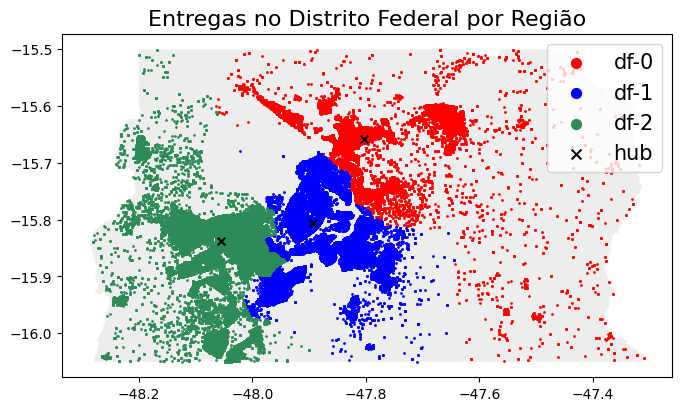

In [63]:
# cria o plot vazio
fig, ax = plt.subplots(figsize = (20/2.54, 20/2.54))

# plot mapa do distrito federal
mapa.plot(ax=ax, alpha=0.4, color="lightgrey")

# plot das entregas
geo_deliveries_df.query("region == 'df-0'").plot(ax=ax, markersize=1, color="red", label="df-0")
geo_deliveries_df.query("region == 'df-1'").plot(ax=ax, markersize=1, color="blue", label="df-1")
geo_deliveries_df.query("region == 'df-2'").plot(ax=ax, markersize=1, color="seagreen", label="df-2")

# plot dos hubs
geo_hub_df.plot(ax=ax, markersize=30, marker="x", color="black", label="hub")

# plot da legenda
plt.title("Entregas no Distrito Federal por Região", fontdict={"fontsize": 16})
lgnd = plt.legend(loc='upper right', prop={"size": 15})
for handle in lgnd.legend_handles:
    handle.set_sizes([50])

Analisando o mapa acima conseguimos visualizar os três hubs (df-0, df-1 e df-2) marcados como um X e cada um representado por uma cor diferente.

**HUB df-0** - Em primeira vista percebemos que os pontos de entregas são mais espaçados, menos densos e com uma distância maior do que os demais.

**HUB df-1** - Claramente é o hub com menos area de entrega e com uma densidade maior que o primeiro.

**HUB df-2** - Com uma area de entrega maior que o segundo e menor que o primeiro, porém com densidade elevada na região próxima ao hub.

###Aqui vou criar uma função para calcular as distancias de cada entrega em relação aos seus respectivos hubs e adicionar outra coluna com as distancias em KM

In [51]:
#variavel para trabalharmos apenas 20% dos dados pra nao demorar muito
sample_df = deliveries_df.sample(frac=0.2, random_state=42)

#Função que calcula a distância entre os pontos
def calcular_distancia(hub_coords, delivery_coords):
    return geodesic(hub_coords, delivery_coords).kilometers

#Aplicando a função ao DF de amostra
sample_df['distance_km'] = sample_df.apply(lambda row: calcular_distancia(
    (row['hub_lat'], row['hub_lng']),
    (row['delivery_lat'], row['delivery_lng'])
), axis=1)

sample_df.head()

#PS. DEMORA CERCA DE 50s


,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat,delivery_city,delivery_suburb,distance_km
47609,cvrp-2-df-8,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,5,-48.050207,-15.837847,Cruzeiro,NaN,0.513304
230546,cvrp-2-df-32,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.102891,-15.810892,Arniqueiras,Vila Areal,5.952137
29489,cvrp-2-df-11,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,6,-48.060918,-15.821688,Arniqueiras,Vila Areal,1.928614
474050,cvrp-1-df-55,df-1,-47.893662,-15.805118,Brasília,Asa Sul,180,2,-47.853723,-15.791186,Ceilândia,Setor O,4.548276
261645,cvrp-1-df-71,df-1,-47.893662,-15.805118,Brasília,Asa Sul,180,7,-47.941510,-15.865256,Planaltina,Setor Tradicional,8.399817


##Vizualizando dados estatisticos por Hub de entrega

In [66]:
#ajustando o pandas para exibir todas as colunas em uma linha só pois o colab estava "quebrando" a couna no meio
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)

#dados estatisticos agrupando a coluna region
statistics_df = sample_df[['region', 'distance_km']].groupby('region').describe()
statistics_df



distance_km                                                                        
             count      mean       std       min       25%       50%        75%        max
region                                                                                    
df-0       14163.0  9.054444  7.302281  0.026288  3.589175  5.946586  15.193798  67.847814
df-1       60839.0  5.952487  3.699896  0.007616  3.536587  5.062953   7.816911  32.509305
df-2       52228.0  7.902185  5.958619  0.006160  3.897809  6.464850   9.072650  39.531695

##Vizualizando a soma das distâncias percorridas para cada região

In [77]:
#somando todas as distancias percorridas
distance_sum_df = sample_df[['region', 'distance_km']].groupby('region').sum()
distance_sum_df

,distance_km
region,
df-0,128238.087685
df-1,362143.335725
df-2,412715.301815


Analisando a soma da distancia percorrida das entregas por hub percebemos que:

**HUB df-0** - tem a menor distância percorrida com 128.238 km

**HUB df-1** - tem a distância de 362.143 km ficando em segundo

**HUB df-2** - com a maior distância de 412.715 km

##Vizualização do gráfico com amostra de 20% dos dados

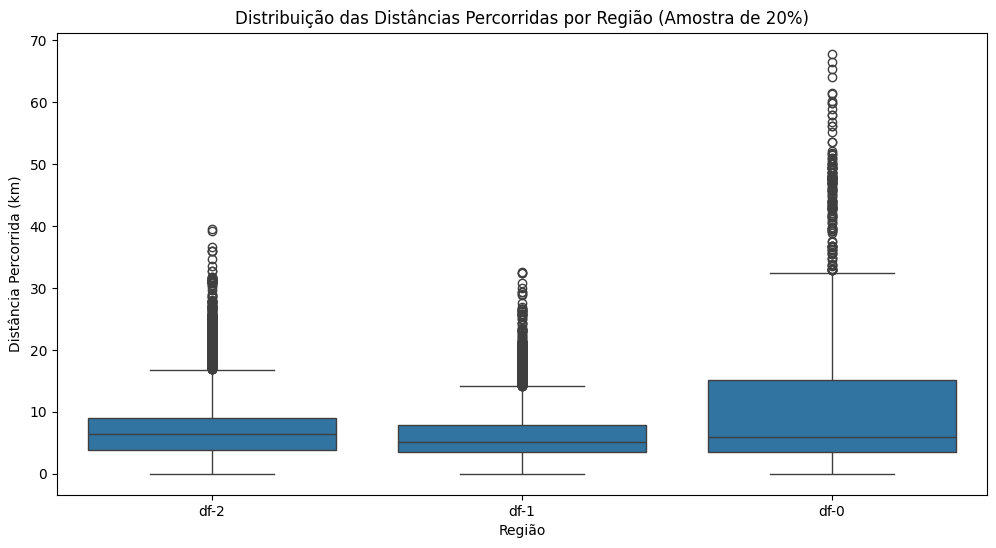

In [78]:

# Visualizando as distâncias percorridas
plt.figure(figsize=(12, 6))
sns.boxplot(data=sample_df, x='region', y='distance_km')
plt.title('Distribuição das Distâncias Percorridas por Região (Amostra de 20%)')
plt.xlabel('Região')
plt.ylabel('Distância Percorrida (km)')
plt.show()

No gráfico acima podemos identificar que:

**HUB df-0** (média 9,05km) - a maior parte das entregas ficam entre 5 e 15 km de distância do hub, porém com uma amostra significativa entre 35 e 55 km e algumas chegando a quase 70 km.

**HUB df-1** (média 5,95km) - tem a menor media ficando entre 3 e 8 km, com uma boa concentração entre 15 e 25km e não passando de 35km de distância

**HUB df-2** (média 7,90)- mé um pouco maior que o segundo hub, a maior parte das entregas estão concentradas entre 5 e 10 km, com uma boa parte entre 17 e 32 km e não passando de 40 km de distância do hub.


##TOP 10 Bairros com maiores numeros de entregas

In [88]:
#Calcula a distância média por bairro
distance_mean_suburb = sample_df.groupby('delivery_suburb')['distance_km'].mean().reset_index()

#Renomeando as colunas
distance_mean_suburb.rename(columns={'delivery_suburb': 'Bairro', 'distance_km': 'Distancia_media_Km'}, inplace=True)

#oerdenando os bairros pela distância média
distance_mean_suburb = distance_mean_suburb.sort_values(by='Distancia_media_Km', ascending=False)

#mostrando o top 10
distance_mean_suburb.head(10)


,Bairro,Distancia_media_Km
57,Núcleo Rural Almécegas,12.237244
120,Setor Residencial Oeste,11.194092
83,Polo JK,10.693083
147,Vila Nova,9.952516
134,Setor de Rádio e TV Norte,9.653226
156,Área Alfa,9.312068
119,Setor Residencial Norte 1 - Buritis II,9.101326
151,Vila São José,9.065247
63,Núcleo Rural da Vargem Bonita,8.990288
41,Expansão do Setor O,8.446631


**A análise acima fornece uma visão clara dos bairros onde a distância média das entregas é maior, ajudando a identificar áreas que podem exigir maior atenção na para melhoramento de logistica.**

#Insights dos dados coletados e tratados

Analisando todos os dados tratados considero que:

Região df-0 com a menor distância total percorrida indicando uma menor demanda de entregas porém com uma densidade de entregas mais distribuída por se tratar de uma região menos populosa.

A região df-1 registra um total de aproximadamente 362.143 km percorridos. Embora menor que df-2, ainda é uma quantidade significativa de deslocamento. Isso sugere que esta região também possui uma alta demanda de entregas por se tratar de uma região mais central.

Com um total de aproximadamente 412.715 km, a região df-2 destaca-se como a região com a maior soma de distâncias percorridas pelos veículos de entrega. Isso pode indicar que df-2 abrange uma área maior e que há uma maior densidade de entregas, exigindo mais deslocamento.

**Considerações**

A análise das distâncias percorridas pode fornecer insights importantes sobre a eficiência operacional. Regiões com altas distâncias percorridas podem estar enfrentando desafios logísticos que poderiam ser otimizados, como a roteirização de entregas para minimizar o deslocamento.

Planejamento de Capacidade: Compreender as demandas de entrega e as distâncias percorridas pode ajudar na alocação de recursos, como a distribuição de veículos e a programação de rotas, para atender de forma mais eficaz às necessidades de cada região.

Impacto Ambiental: Reduzir as distâncias percorridas não só melhora a eficiência operacional, mas também contribui para a diminuição das emissões de CO₂, ajudando a empresa a atingir metas de sustentabilidade.